In [2]:
import cv2
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lung-and-colon-cancer-histopathological-images


## Data Preparation

In [4]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)

    return np.array(images)

In [5]:
# Base paths (use kagglehub path instead of hardcoded /kaggle/input/)
base_path_lung = os.path.join(path, "lung_colon_image_set", "lung_image_sets")
base_path_colon = os.path.join(path, "lung_colon_image_set", "colon_image_sets")

# Load lung cancer images
benign_lung = load_images(os.path.join(base_path_lung, "lung_n"))
mal_aca_lung = load_images(os.path.join(base_path_lung, "lung_aca"))
mal_scc_lung = load_images(os.path.join(base_path_lung, "lung_scc"))

# Load colon cancer images
benign_colon = load_images(os.path.join(base_path_colon, "colon_n"))
mal_aca_colon = load_images(os.path.join(base_path_colon, "colon_aca"))

# Combine samples and labels
samples = np.concatenate((benign_lung, mal_aca_lung, mal_scc_lung, benign_colon, mal_aca_colon))
labels = np.array(
    [0] * benign_lung.shape[0] +
    [1] * mal_aca_lung.shape[0] +
    [2] * mal_scc_lung.shape[0] +
    [3] * benign_colon.shape[0] +
    [4] * mal_aca_colon.shape[0]
)

# Shuffle dataset
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)
samples = samples[indices]
labels = labels[indices]

# Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

# Normalize to [0, 1]
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (20000, 80, 80, 3) Val: (2500, 80, 80, 3) Test: (2500, 80, 80, 3)


## feature extraction

In [6]:
from cuml.cluster import KMeans as cuKMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def extract_color_features(images):
    features = []

    for img in images:
        # Calculate average RGB values
        avg_color_per_channel = np.mean(img, axis=(0, 1))

        # Calculate standard deviation of RGB values
        std_color_per_channel = np.std(img, axis=(0, 1))

        # Calculate histograms for each channel
        hist_b = np.histogram(img[:,:,0], bins=32, range=(0, 1))[0] / (img.shape[0] * img.shape[1])
        hist_g = np.histogram(img[:,:,1], bins=32, range=(0, 1))[0] / (img.shape[0] * img.shape[1])
        hist_r = np.histogram(img[:,:,2], bins=32, range=(0, 1))[0] / (img.shape[0] * img.shape[1])

        # Convert to HSV color space for additional features
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        avg_hsv = np.mean(hsv_img, axis=(0, 1))
        std_hsv = np.std(hsv_img, axis=(0, 1))

        # Calculate dominant colors using K-means
        # Reshape image for K-means
        pixels = img.reshape(-1, 3)
        # Use a small sample of pixels for speed (optional)
        pixels_sample = pixels[::20]  # Take every 20th pixel
        pixels_sample = pixels_sample.astype(np.float32)  # Ensure float32 format for cuML compatibility
        # kmeans = KMeans(n_clusters=5, n_init=10, random_state=42).fit(pixels_sample)
        kmeans = cuKMeans(n_clusters=5, n_init=10, random_state=42)
        kmeans.fit(pixels_sample)
        dominant_colors = kmeans.cluster_centers_
        color_counts = np.bincount(kmeans.labels_)
        # Calculate color percentages
        color_percentages = color_counts / len(pixels_sample)

        # Create feature vector by combining all extracted features
        feature_vector = np.concatenate([
            avg_color_per_channel,         # 3 features (mean R, G, B)
            std_color_per_channel,         # 3 features (std R, G, B)
            hist_b, hist_g, hist_r,        # 96 features (32 bins × 3 channels)
            avg_hsv,                       # 3 features (mean H, S, V)
            std_hsv,                       # 3 features (std H, S, V)
            dominant_colors.flatten(),     # 15 features (5 dominant colors × 3 channels)
            color_percentages              # 5 features (percentage of each dominant color)
        ])

        features.append(feature_vector)

    return np.array(features)

In [7]:
# Extract color features
X_train_features = extract_color_features(X_train)
X_val_features = extract_color_features(X_val)
X_test_features = extract_color_features(X_test)

# Normalize the features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_val_features_scaled = scaler.transform(X_val_features)
X_test_features_scaled = scaler.transform(X_test_features)

In [8]:
X_train_features.shape

(20000, 128)

## analyze the average color differences between classes:

In [9]:
# Function to compute average color metrics by class
def analyze_color_by_class(images, labels, class_names):
    class_colors = {}

    # For each class
    for class_id in range(len(class_names)):
        # Get images for this class
        class_images = images[labels == class_id]

        if len(class_images) == 0:
            continue

        # Calculate average RGB
        avg_rgb = np.mean(class_images, axis=(0, 1, 2))

        # Convert to BGR for OpenCV
        class_images_cv = class_images.copy()

        # Convert to HSV and calculate average
        hsv_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in class_images_cv])
        avg_hsv = np.mean(hsv_images, axis=(0, 1, 2))

        # Store metrics
        class_colors[class_id] = {
            'avg_rgb': avg_rgb,
            'avg_hsv': avg_hsv,
            'name': class_names[class_id]
        }

    return class_colors

# Define class names
class_names = ['Lung Benign', 'Lung Adenocarcinoma', 'Lung Squamous Cell Carcinoma',
               'Colon Benign', 'Colon Adenocarcinoma']

# Analyze color differences (use original labels, not one-hot encoded)
color_analysis = analyze_color_by_class(X_train, y_train, class_names)

# Display the results
print("Average color metrics by class:")
for class_id, data in color_analysis.items():
    print(f"\n{data['name']}:")
    print(f"  Average RGB: R={data['avg_rgb'][0]:.3f}, G={data['avg_rgb'][1]:.3f}, B={data['avg_rgb'][2]:.3f}")
    print(f"  Average HSV: H={data['avg_hsv'][0]:.3f}, S={data['avg_hsv'][1]:.3f}, V={data['avg_hsv'][2]:.3f}")

Average color metrics by class:

Lung Benign:
  Average RGB: R=0.655, G=0.655, B=0.655
  Average HSV: H=278.319, S=0.256, V=0.655

Lung Adenocarcinoma:
  Average RGB: R=0.655, G=0.536, B=0.655
  Average HSV: H=318.819, S=0.423, V=0.655

Lung Squamous Cell Carcinoma:
  Average RGB: R=0.655, G=0.448, B=0.654
  Average HSV: H=335.544, S=0.478, V=0.655

Colon Benign:
  Average RGB: R=0.655, G=0.655, B=0.655
  Average HSV: H=335.544, S=0.232, V=0.655

Colon Adenocarcinoma:
  Average RGB: R=0.655, G=0.655, B=0.655
  Average HSV: H=335.544, S=0.264, V=0.655


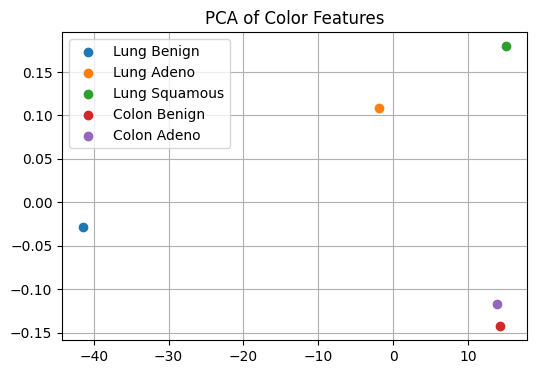

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

classes = [
    "Lung Benign", "Lung Adeno", "Lung Squamous",
    "Colon Benign", "Colon Adeno"
]

# Average RGB and HSV
rgb = np.array([
    [0.656, 0.656, 0.656],
    [0.655, 0.536, 0.655],
    [0.657, 0.446, 0.652],
    [0.655, 0.655, 0.655],
    [0.654, 0.654, 0.654]
])

hsv = np.array([
    [279.646, 0.257, 0.656],
    [319.229, 0.423, 0.655],
    [336.133, 0.479, 0.657],
    [335.293, 0.232, 0.655],
    [334.958, 0.263, 0.654]
])

features = np.hstack((rgb, hsv))  # shape (5, 6)
pca = PCA(n_components=2)
reduced = pca.fit_transform(features)

plt.figure(figsize=(6, 4))
for i, label in enumerate(classes):
    plt.scatter(reduced[i, 0], reduced[i, 1], label=label)
plt.title("PCA of Color Features")
plt.legend()
plt.grid(True)
plt.show()


## visualize the color distributions using PCA

In [ ]:
# # Perform PCA on color features
# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train_features_scaled)

# # Plot PCA results colored by class
# plt.figure(figsize=(10, 8))
# for i, class_name in enumerate(class_names):
#     indices = np.where(y_train == i)[0]
#     plt.scatter(X_train_pca[indices, 0], X_train_pca[indices, 1], label=class_name, alpha=0.7)

# plt.title('PCA of Color Features')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.savefig('color_features_pca.png')
# plt.show()

# # Calculate feature importance
# feature_importance = np.abs(pca.components_)
# top_features = np.argsort(feature_importance.sum(axis=0))[-10:]  # Top 10 features

# print("\nTop 10 important features:")
# for idx in top_features:
#     print(f"Feature {idx}: Importance = {feature_importance.sum(axis=0)[idx]:.4f}")

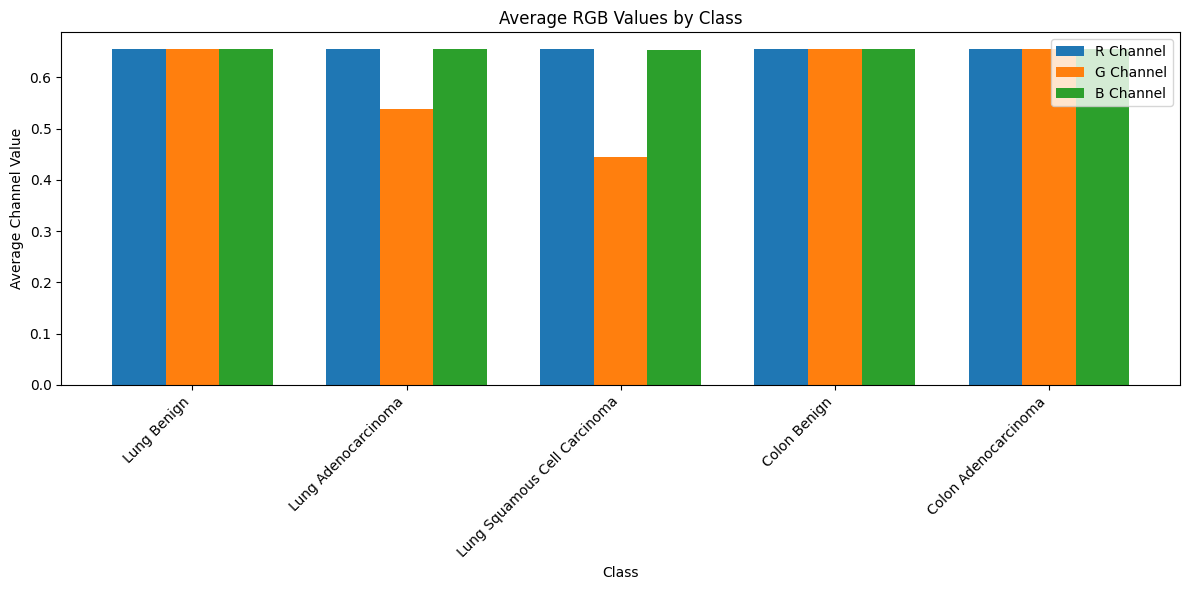

In [ ]:
# Create bar chart of RGB averages by class
rgb_means = np.array([data['avg_rgb'] for data in color_analysis.values()])
class_labels = [data['name'] for data in color_analysis.values()]

plt.figure(figsize=(12, 6))
x = np.arange(len(class_labels))
width = 0.25

plt.bar(x - width, rgb_means[:, 0], width, label='R Channel')
plt.bar(x, rgb_means[:, 1], width, label='G Channel')
plt.bar(x + width, rgb_means[:, 2], width, label='B Channel')

plt.xlabel('Class')
plt.ylabel('Average Channel Value')
plt.title('Average RGB Values by Class')
plt.xticks(x, class_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('avg_rgb_by_class.png')
plt.show()

# Models Validation

Logistic Regression: mean=0.9607, std=0.0020
Random Forest: mean=0.9973, std=0.0008
SVM (RBF): mean=0.9780, std=0.0013
KNN (k=5): mean=0.9733, std=0.0024

Best by CV: Random Forest (mean=0.9973)
Test accuracy with 'Random Forest': 0.9984


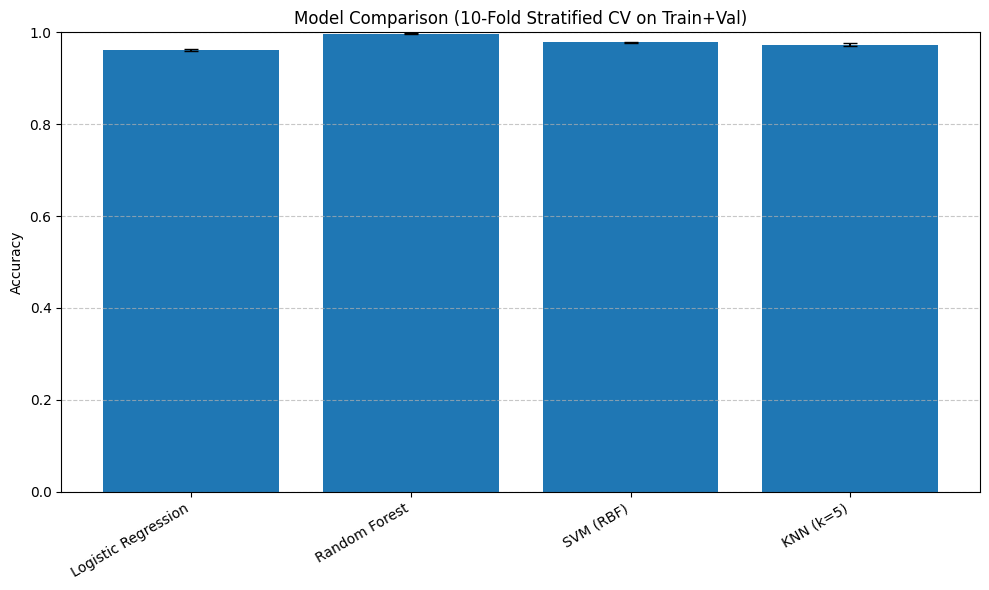

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ==== Models to compare ====
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf"),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

# ==== Use your prepared features ====
# Cross-validate on train+val; keep test for final evaluation
X_cv = np.vstack([X_train_features_scaled, X_val_features_scaled])
y_cv = np.hstack([y_train, y_val])

# ==== Stratified 10-fold CV ====
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_cv, y_cv, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_scores[name] = scores
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")

# ==== Pick best by mean CV accuracy ====
best_model_name = max(cv_scores, key=lambda k: cv_scores[k].mean())
best_model = models[best_model_name]
print(f"\nBest by CV: {best_model_name} (mean={cv_scores[best_model_name].mean():.4f})")

# ==== Retrain best model on full train+val and test once ====
best_model.fit(X_cv, y_cv)
y_test_pred = best_model.predict(X_test_features_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy with '{best_model_name}': {test_acc:.4f}")

# ==== Plot CV means with error bars ====
plt.figure(figsize=(10, 6))
labels_plot = list(cv_scores.keys())
means = [np.mean(cv_scores[k]) for k in labels_plot]
stds = [np.std(cv_scores[k]) for k in labels_plot]
plt.bar(labels_plot, means, yerr=stds, capsize=5)
plt.title("Model Comparison (10-Fold Stratified CV on Train+Val)")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Logistic Regression Accuracy: 0.9576


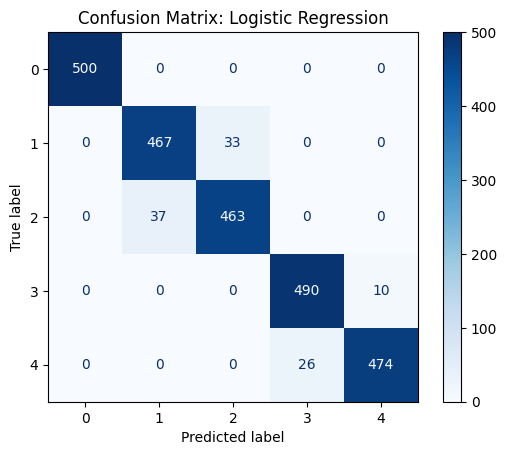

Random Forest Accuracy: 0.9976


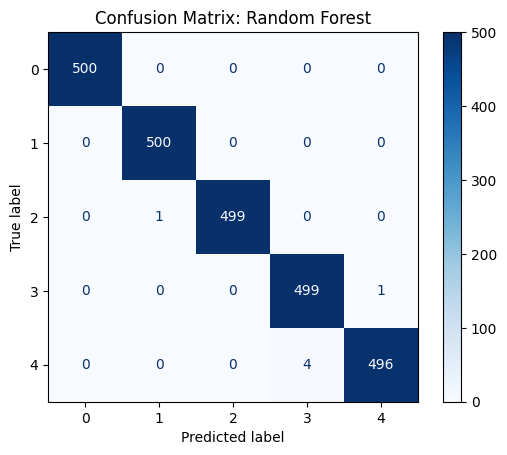

SVM Accuracy: 0.9764


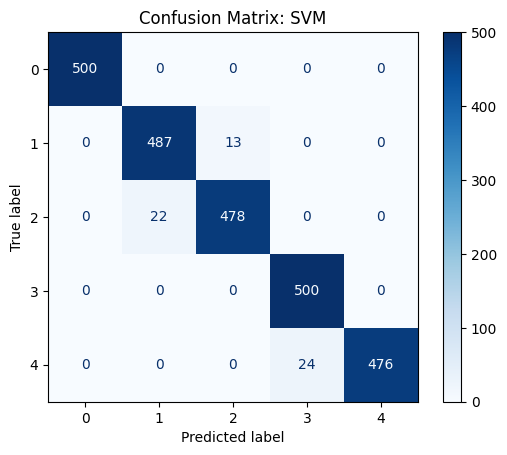

KNN Accuracy: 0.9736


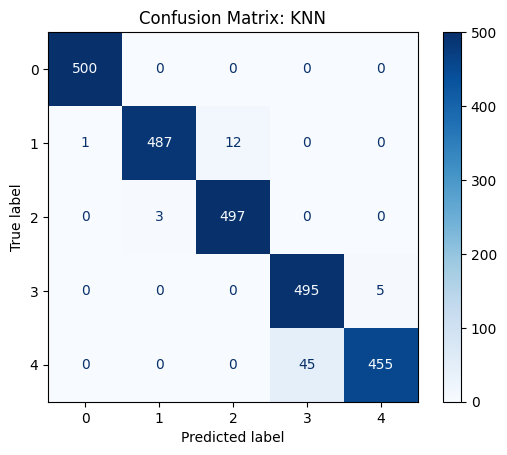

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dictionary of models to try
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

best_model = None
best_model_name = ""
best_accuracy = 0.0

# Dictionary to store model performances
results = {}

# Train, evaluate, and plot confusion matrix for each model
for name, model in models.items():
    model.fit(X_train_features_scaled, y_train)
    y_pred = model.predict(X_val_features_scaled)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

    # Save the best model
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# # Plotting the comparison
# plt.figure(figsize=(7, 5))
# plt.bar(results.keys(), results.values(), color='skyblue')
# plt.title("Model Comparison on Validation Set")
# plt.ylabel("Accuracy")
# plt.xticks(rotation=45)
# plt.ylim(0, 1)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


save the best model

In [13]:
import joblib

# Save the best model to a file
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
print(f"Saved best model as best_model_{best_model_name.replace(' ', '_')}.pkl")

Saved best model as best_model_Random_Forest.pkl


# Test


Best model: Random Forest with accuracy 0.9976 on validation data
Test Accuracy of best model: 0.9980


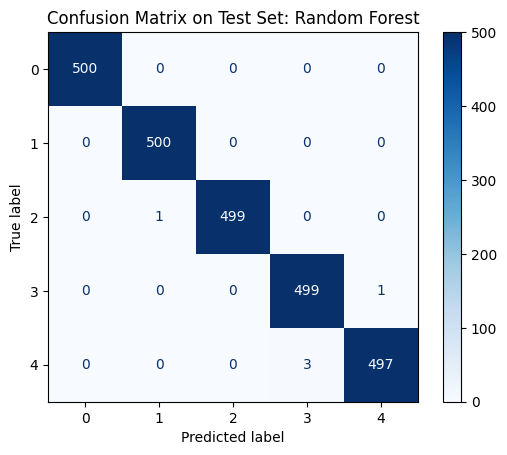

In [34]:
# Evaluate the best model on the test set
print(f"\nBest model: {best_model_name} with accuracy {best_accuracy:.4f} on validation data")
y_test_pred = best_model.predict(X_test_features_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy of best model: {test_acc:.4f}")

# Plot confusion matrix on test set
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix on Test Set: {best_model_name}")
plt.show()

# SHAP on Random Forest Model

Calculating SHAP values...
Total number of features: 128


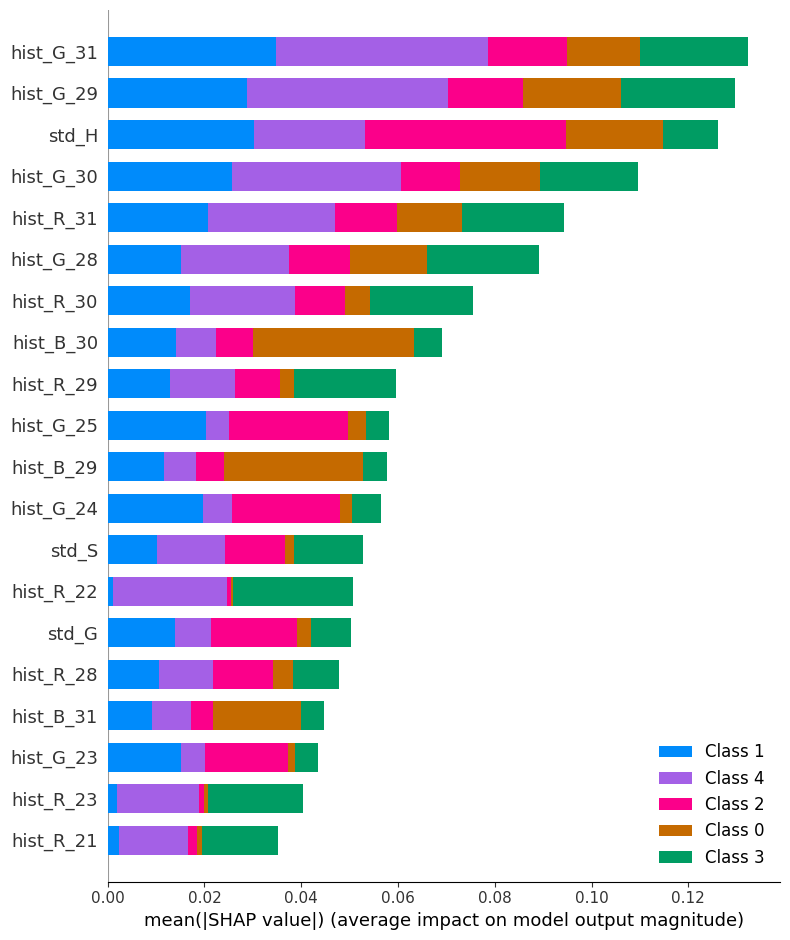

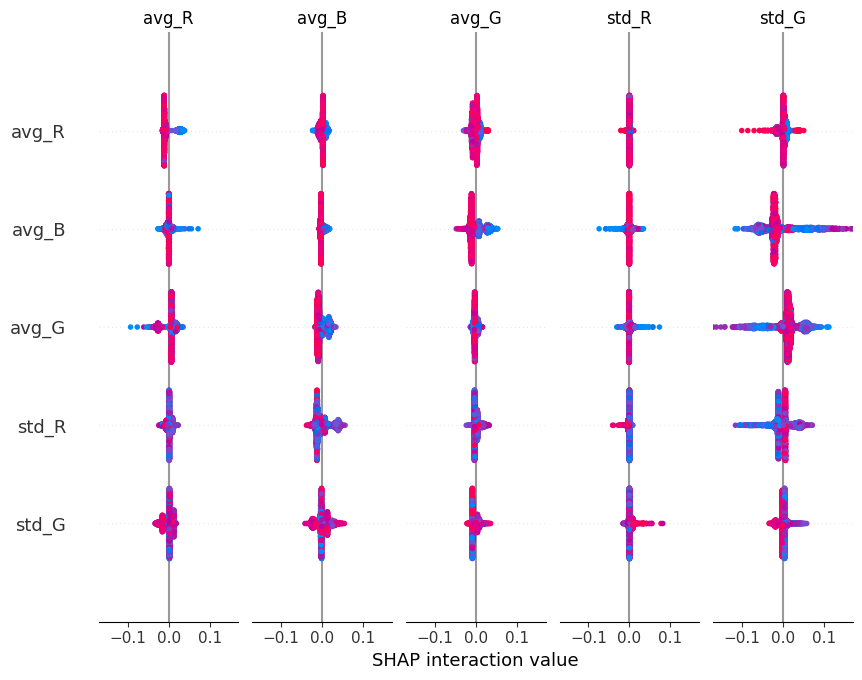

In [15]:
# -------------------------------
# Step 2: Explain the best model using SHAP
# -------------------------------

import shap
import pandas as pd

# Choose the SHAP explainer based on the model type
if best_model_name.lower().replace(" ", "") in ['randomforest', 'xgboost', 'lightgbm']:
    explainer = shap.TreeExplainer(best_model)
else:
    raise ValueError(f"Unsupported model type for SHAP: {best_model_name}")

# Compute SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_val_features_scaled)

# -------------------------------
# Step 3: Build the feature names
# -------------------------------

feature_names = []
# 1. Average RGB
feature_names += ['avg_R', 'avg_G', 'avg_B']
# 2. Std RGB
feature_names += ['std_R', 'std_G', 'std_B']
# 3. Histogram bins
feature_names += [f'hist_B_{i}' for i in range(32)]
feature_names += [f'hist_G_{i}' for i in range(32)]
feature_names += [f'hist_R_{i}' for i in range(32)]
# 4. Average HSV
feature_names += ['avg_H', 'avg_S', 'avg_V']
# 5. Std HSV
feature_names += ['std_H', 'std_S', 'std_V']
# 6. Dominant colors (5 clusters × 3 channels)
for i in range(5):
    feature_names += [f'domColor_{i}_R', f'domColor_{i}_G', f'domColor_{i}_B']
# 7. Color percentages (5 clusters)
feature_names += [f'domColor_{i}_pct' for i in range(5)]

print(f"Total number of features: {len(feature_names)}")  # Should be 128

# -------------------------------
# Step 4: Plot Feature Importance
# -------------------------------

X_df = pd.DataFrame(X_val_features_scaled, columns=feature_names)

# Handle multiclass shap_values if returned as list
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[0]
else:
    shap_values_to_plot = shap_values

# Plot SHAP feature importance
shap.summary_plot(shap_values_to_plot, X_df, plot_type="bar")
shap.summary_plot(shap_values_to_plot, X_df)


# ROC

Multiclass ROC AUC (OvR, macro): 1.000


<Figure size 800x600 with 0 Axes>

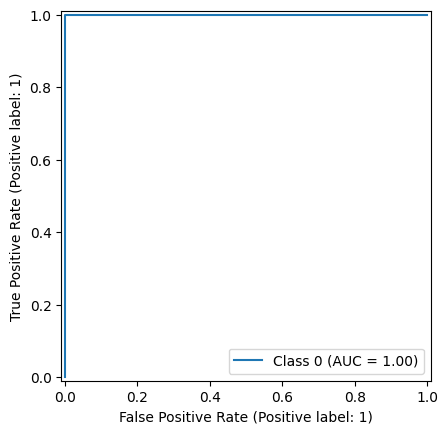

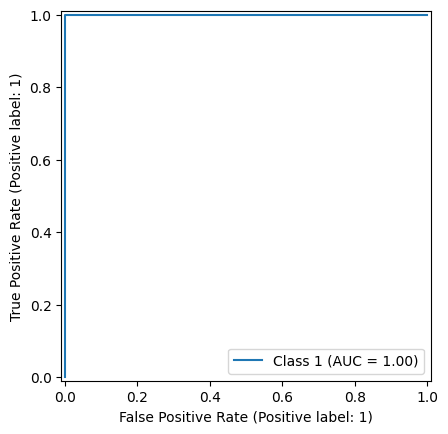

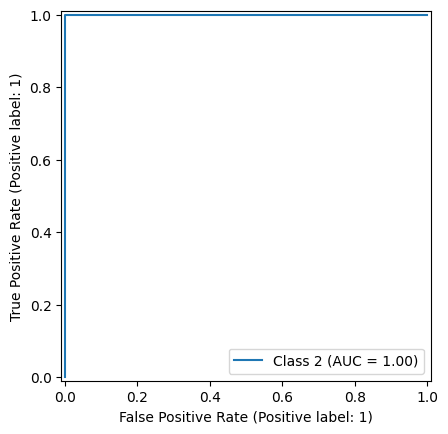

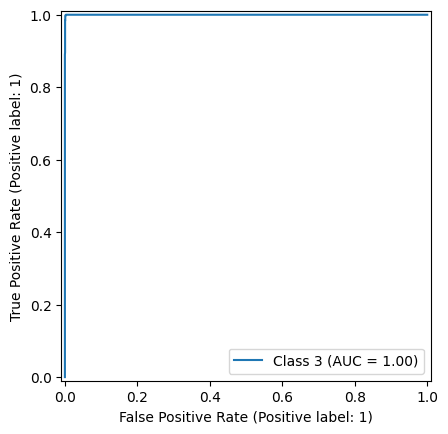

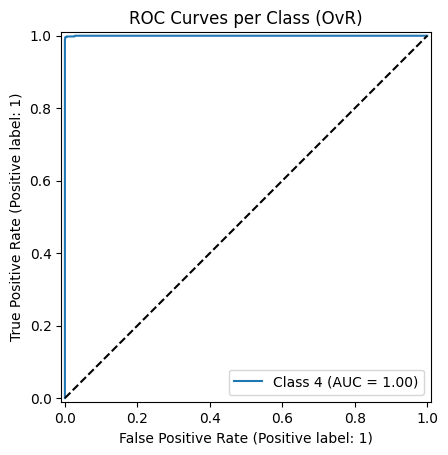

In [19]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_test_prob = best_model.predict_proba(X_test_features_scaled)  # shape (n_samples, n_classes)

roc_auc = roc_auc_score(y_test, y_test_prob, multi_class="ovr", average="macro")
print(f"Multiclass ROC AUC (OvR, macro): {roc_auc:.3f}")

# Plot ROC per class
from sklearn.preprocessing import label_binarize
n_classes = y_test_prob.shape[1]
y_test_bin = label_binarize(y_test, classes=range(n_classes))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i], y_test_prob[:, i], name=f"Class {i}"
    )
plt.plot([0, 1], [0, 1], "k--")
plt.title(f"ROC Curves per Class (OvR)")
plt.show()


# soft classification (split based on probabilities)

statistical analysis

In [30]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

class MulticlassConfidenceAnalyzer:
    def __init__(self, y_true, y_prob, confidence_threshold=0.8):
        """
        Analyze confidence in multiclass predictions

        Args:
            y_true: True labels (shape: n_samples,)
            y_prob: Probability predictions (shape: n_samples, n_classes)
            confidence_threshold: Threshold for confident predictions (default: 0.8)
        """
        self.y_true = y_true
        self.y_prob = y_prob
        self.confidence_threshold = confidence_threshold

        # Get the maximum probability for each prediction (confidence score)
        self.max_probs = np.max(y_prob, axis=1)

        # Get predicted classes (argmax)
        self.y_pred = np.argmax(y_prob, axis=1)

        # Create confidence masks
        self.confident_mask = self.max_probs >= confidence_threshold
        self.uncertain_mask = ~self.confident_mask

        # Split data into confident and uncertain groups
        self.confident_probs = self.max_probs[self.confident_mask]
        self.uncertain_probs = self.max_probs[self.uncertain_mask]
        self.confident_true = y_true[self.confident_mask]
        self.uncertain_true = y_true[self.uncertain_mask]
        self.confident_pred = self.y_pred[self.confident_mask]
        self.uncertain_pred = self.y_pred[self.uncertain_mask]

        # Store full probability matrices for each group
        self.confident_prob_matrix = y_prob[self.confident_mask]
        self.uncertain_prob_matrix = y_prob[self.uncertain_mask]

    def basic_statistics(self):
        """Calculate basic descriptive statistics"""
        print("="*60)
        print("BASIC STATISTICS - MULTICLASS CONFIDENCE ANALYSIS")
        print("="*60)

        # Overall statistics
        print(f"Total samples: {len(self.y_true)}")
        print(f"Number of classes: {self.y_prob.shape[1]}")
        print(f"Confidence threshold: {self.confidence_threshold}")
        print(f"Confident predictions: {len(self.confident_probs)} ({len(self.confident_probs)/len(self.y_true)*100:.1f}%)")
        print(f"Uncertain predictions: {len(self.uncertain_probs)} ({len(self.uncertain_probs)/len(self.y_true)*100:.1f}%)")

        # Confidence score distributions
        print(f"\nConfidence Score Distribution:")
        print(f"Overall - Mean: {self.max_probs.mean():.4f}, Std: {self.max_probs.std():.4f}")
        print(f"Overall - Min: {self.max_probs.min():.4f}, Max: {self.max_probs.max():.4f}")

        if len(self.confident_probs) > 0:
            print(f"Confident - Mean: {self.confident_probs.mean():.4f}, Std: {self.confident_probs.std():.4f}")
            print(f"Confident - Min: {self.confident_probs.min():.4f}, Max: {self.confident_probs.max():.4f}")

        if len(self.uncertain_probs) > 0:
            print(f"Uncertain - Mean: {self.uncertain_probs.mean():.4f}, Std: {self.uncertain_probs.std():.4f}")
            print(f"Uncertain - Min: {self.uncertain_probs.min():.4f}, Max: {self.uncertain_probs.max():.4f}")

        # Class distribution analysis
        print(f"\nClass Distribution Analysis:")
        unique_classes = np.unique(self.y_true)

        print("Overall class distribution:")
        for cls in unique_classes:
            count = np.sum(self.y_true == cls)
            print(f"  Class {cls}: {count} ({count/len(self.y_true)*100:.1f}%)")

        if len(self.confident_true) > 0:
            print("Confident group class distribution:")
            for cls in unique_classes:
                count = np.sum(self.confident_true == cls)
                print(f"  Class {cls}: {count} ({count/len(self.confident_true)*100:.1f}%)")

        if len(self.uncertain_true) > 0:
            print("Uncertain group class distribution:")
            for cls in unique_classes:
                count = np.sum(self.uncertain_true == cls)
                print(f"  Class {cls}: {count} ({count/len(self.uncertain_true)*100:.1f}%)")

    def performance_metrics(self):
        """Calculate performance metrics for each group"""
        print("\n" + "="*60)
        print("PERFORMANCE METRICS")
        print("="*60)

        # Overall performance
        overall_metrics = {
            'Accuracy': accuracy_score(self.y_true, self.y_pred),
            'Precision (macro)': precision_score(self.y_true, self.y_pred, average='macro', zero_division=0),
            'Recall (macro)': recall_score(self.y_true, self.y_pred, average='macro', zero_division=0),
            'F1-Score (macro)': f1_score(self.y_true, self.y_pred, average='macro', zero_division=0),
            'Precision (weighted)': precision_score(self.y_true, self.y_pred, average='weighted', zero_division=0),
            'Recall (weighted)': recall_score(self.y_true, self.y_pred, average='weighted', zero_division=0),
            'F1-Score (weighted)': f1_score(self.y_true, self.y_pred, average='weighted', zero_division=0)
        }

        print("Overall Performance:")
        for metric, value in overall_metrics.items():
            print(f"  {metric}: {value:.4f}")

        # Confident group performance
        if len(self.confident_true) > 0:
            conf_metrics = {
                'Accuracy': accuracy_score(self.confident_true, self.confident_pred),
                'Precision (macro)': precision_score(self.confident_true, self.confident_pred, average='macro', zero_division=0),
                'Recall (macro)': recall_score(self.confident_true, self.confident_pred, average='macro', zero_division=0),
                'F1-Score (macro)': f1_score(self.confident_true, self.confident_pred, average='macro', zero_division=0),
                'Precision (weighted)': precision_score(self.confident_true, self.confident_pred, average='weighted', zero_division=0),
                'Recall (weighted)': recall_score(self.confident_true, self.confident_pred, average='weighted', zero_division=0),
                'F1-Score (weighted)': f1_score(self.confident_true, self.confident_pred, average='weighted', zero_division=0)
            }

            print(f"\nConfident Group Performance (n={len(self.confident_true)}):")
            for metric, value in conf_metrics.items():
                print(f"  {metric}: {value:.4f}")

        # Uncertain group performance
        if len(self.uncertain_true) > 0:
            unc_metrics = {
                'Accuracy': accuracy_score(self.uncertain_true, self.uncertain_pred),
                'Precision (macro)': precision_score(self.uncertain_true, self.uncertain_pred, average='macro', zero_division=0),
                'Recall (macro)': recall_score(self.uncertain_true, self.uncertain_pred, average='macro', zero_division=0),
                'F1-Score (macro)': f1_score(self.uncertain_true, self.uncertain_pred, average='macro', zero_division=0),
                'Precision (weighted)': precision_score(self.uncertain_true, self.uncertain_pred, average='weighted', zero_division=0),
                'Recall (weighted)': recall_score(self.uncertain_true, self.uncertain_pred, average='weighted', zero_division=0),
                'F1-Score (weighted)': f1_score(self.uncertain_true, self.uncertain_pred, average='weighted', zero_division=0)
            }

            print(f"\nUncertain Group Performance (n={len(self.uncertain_true)}):")
            for metric, value in unc_metrics.items():
                print(f"  {metric}: {value:.4f}")

    def statistical_tests(self):
        """Perform statistical tests between confident and uncertain groups"""
        print("\n" + "="*60)
        print("STATISTICAL TESTS")
        print("="*60)

        # Test 1: Mann-Whitney U test for confidence score distributions
        if len(self.confident_probs) > 0 and len(self.uncertain_probs) > 0:
            stat, p_value = stats.mannwhitneyu(
                self.confident_probs, self.uncertain_probs,
                alternative='two-sided'
            )
            print(f"Mann-Whitney U Test (Confidence Score Distributions):")
            print(f"  Statistic: {stat:.4f}")
            print(f"  P-value: {p_value:.6f}")
            print(f"  Interpretation: {'Significantly different' if p_value < 0.05 else 'Not significantly different'}")

        # Test 2: Chi-square test for prediction accuracy differences
        if len(self.confident_true) > 0 and len(self.uncertain_true) > 0:
            # Create contingency table
            conf_correct = (self.confident_true == self.confident_pred).sum()
            conf_incorrect = len(self.confident_true) - conf_correct
            unc_correct = (self.uncertain_true == self.uncertain_pred).sum()
            unc_incorrect = len(self.uncertain_true) - unc_correct

            contingency = np.array([[conf_correct, conf_incorrect],
                                   [unc_correct, unc_incorrect]])

            chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

            print(f"\nChi-square Test (Accuracy Differences):")
            print(f"  Chi-square statistic: {chi2:.4f}")
            print(f"  P-value: {p_value:.6f}")
            print(f"  Degrees of freedom: {dof}")
            print(f"  Interpretation: {'Significantly different accuracies' if p_value < 0.05 else 'No significant accuracy difference'}")

        # Test 3: Kolmogorov-Smirnov test for distribution differences
        if len(self.confident_probs) > 0 and len(self.uncertain_probs) > 0:
            ks_stat, ks_p = stats.ks_2samp(self.confident_probs, self.uncertain_probs)
            print(f"\nKolmogorov-Smirnov Test (Distribution Shape):")
            print(f"  KS statistic: {ks_stat:.4f}")
            print(f"  P-value: {ks_p:.6f}")
            print(f"  Interpretation: {'Different distributions' if ks_p < 0.05 else 'Similar distributions'}")

    def entropy_analysis(self):
        """Analyze prediction entropy for uncertainty quantification"""
        print("\n" + "="*60)
        print("ENTROPY ANALYSIS")
        print("="*60)

        # Calculate entropy for all predictions
        epsilon = 1e-10  # To avoid log(0)
        entropy_all = -np.sum(self.y_prob * np.log(self.y_prob + epsilon), axis=1)

        # Split entropy by confidence groups
        if len(self.confident_mask) > 0:
            entropy_confident = entropy_all[self.confident_mask]
        else:
            entropy_confident = np.array([])

        if len(self.uncertain_mask) > 0:
            entropy_uncertain = entropy_all[self.uncertain_mask]
        else:
            entropy_uncertain = np.array([])

        print(f"Entropy Statistics:")
        print(f"Overall - Mean: {entropy_all.mean():.4f}, Std: {entropy_all.std():.4f}")
        print(f"Overall - Min: {entropy_all.min():.4f}, Max: {entropy_all.max():.4f}")

        if len(entropy_confident) > 0:
            print(f"Confident - Mean: {entropy_confident.mean():.4f}, Std: {entropy_confident.std():.4f}")

        if len(entropy_uncertain) > 0:
            print(f"Uncertain - Mean: {entropy_uncertain.mean():.4f}, Std: {entropy_uncertain.std():.4f}")

        # Statistical test for entropy differences
        if len(entropy_confident) > 0 and len(entropy_uncertain) > 0:
            stat, p_value = stats.mannwhitneyu(entropy_confident, entropy_uncertain, alternative='two-sided')
            print(f"\nMann-Whitney U Test (Entropy Differences):")
            print(f"  P-value: {p_value:.6f}")
            print(f"  Interpretation: {'Significantly different entropies' if p_value < 0.05 else 'No significant entropy difference'}")

        return entropy_all, entropy_confident, entropy_uncertain

    def create_comprehensive_plots(self):
        """Create comprehensive visualization plots"""
        fig, axes = plt.subplots(3, 3, figsize=(20, 18))
        fig.suptitle('Comprehensive Multiclass Confidence Analysis', fontsize=16, y=0.98)

        # Plot 1: Confidence score distributions
        axes[0, 0].hist(self.confident_probs, bins=20, alpha=0.7, label="Confident", color='blue')
        axes[0, 0].hist(self.uncertain_probs, bins=20, alpha=0.7, label="Uncertain", color='orange')
        axes[0, 0].axvline(self.confidence_threshold, color="red", linestyle="--",
                          label=f"Threshold = {self.confidence_threshold}")
        axes[0, 0].set_xlabel("Max Probability (Confidence Score)")
        axes[0, 0].set_ylabel("Count")
        axes[0, 0].set_title("Distribution of Confident vs Uncertain Predictions")
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Box plot comparison
        if len(self.confident_probs) > 0 and len(self.uncertain_probs) > 0:
            data_for_box = [self.confident_probs, self.uncertain_probs]
            axes[0, 1].boxplot(data_for_box, labels=['Confident', 'Uncertain'])
        axes[0, 1].set_ylabel("Confidence Score")
        axes[0, 1].set_title("Confidence Score Distribution Comparison")
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Overall confusion matrix
        cm_overall = confusion_matrix(self.y_true, self.y_pred)
        sns.heatmap(cm_overall, annot=True, fmt='d', ax=axes[0, 2], cmap='Blues')
        axes[0, 2].set_title('Overall Confusion Matrix')
        axes[0, 2].set_xlabel('Predicted Class')
        axes[0, 2].set_ylabel('True Class')

        # Plot 4: Confident group confusion matrix
        if len(self.confident_true) > 0 and len(np.unique(self.confident_true)) > 1:
            cm_conf = confusion_matrix(self.confident_true, self.confident_pred)
            sns.heatmap(cm_conf, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
            axes[1, 0].set_title('Confident Group Confusion Matrix')
            axes[1, 0].set_xlabel('Predicted Class')
            axes[1, 0].set_ylabel('True Class')

        # Plot 5: Uncertain group confusion matrix
        if len(self.uncertain_true) > 0 and len(np.unique(self.uncertain_true)) > 1:
            cm_unc = confusion_matrix(self.uncertain_true, self.uncertain_pred)
            sns.heatmap(cm_unc, annot=True, fmt='d', ax=axes[1, 1], cmap='Oranges')
            axes[1, 1].set_title('Uncertain Group Confusion Matrix')
            axes[1, 1].set_xlabel('Predicted Class')
            axes[1, 1].set_ylabel('True Class')

        # Plot 6: Performance metrics comparison
        if len(self.confident_true) > 0 and len(self.uncertain_true) > 0:
            metrics = ['Accuracy', 'Precision\n(macro)', 'Recall\n(macro)', 'F1-Score\n(macro)']
            conf_scores = [
                accuracy_score(self.confident_true, self.confident_pred),
                precision_score(self.confident_true, self.confident_pred, average='macro', zero_division=0),
                recall_score(self.confident_true, self.confident_pred, average='macro', zero_division=0),
                f1_score(self.confident_true, self.confident_pred, average='macro', zero_division=0)
            ]
            unc_scores = [
                accuracy_score(self.uncertain_true, self.uncertain_pred),
                precision_score(self.uncertain_true, self.uncertain_pred, average='macro', zero_division=0),
                recall_score(self.uncertain_true, self.uncertain_pred, average='macro', zero_division=0),
                f1_score(self.uncertain_true, self.uncertain_pred, average='macro', zero_division=0)
            ]

            x = np.arange(len(metrics))
            width = 0.35

            axes[1, 2].bar(x - width/2, conf_scores, width, label='Confident', alpha=0.8, color='blue')
            axes[1, 2].bar(x + width/2, unc_scores, width, label='Uncertain', alpha=0.8, color='orange')
            axes[1, 2].set_xlabel('Metrics')
            axes[1, 2].set_ylabel('Score')
            axes[1, 2].set_title('Performance Metrics Comparison')
            axes[1, 2].set_xticks(x)
            axes[1, 2].set_xticklabels(metrics)
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)

        # Plot 7: Sample size distribution
        sizes = [len(self.confident_probs), len(self.uncertain_probs)]
        labels = [f'Confident\n(n={sizes[0]})', f'Uncertain\n(n={sizes[1]})']
        colors = ['blue', 'orange']

        axes[2, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[2, 0].set_title('Sample Size Distribution')

        # Plot 8: Entropy analysis
        epsilon = 1e-10
        entropy_all = -np.sum(self.y_prob * np.log(self.y_prob + epsilon), axis=1)
        entropy_confident = entropy_all[self.confident_mask] if len(self.confident_mask) > 0 else []
        entropy_uncertain = entropy_all[self.uncertain_mask] if len(self.uncertain_mask) > 0 else []

        if len(entropy_confident) > 0:
            axes[2, 1].hist(entropy_confident, bins=20, alpha=0.7, label="Confident", color='blue')
        if len(entropy_uncertain) > 0:
            axes[2, 1].hist(entropy_uncertain, bins=20, alpha=0.7, label="Uncertain", color='orange')
        axes[2, 1].set_xlabel("Prediction Entropy")
        axes[2, 1].set_ylabel("Count")
        axes[2, 1].set_title("Entropy Distribution Comparison")
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)

        # Plot 9: Confidence vs Accuracy scatter
        if len(self.max_probs) > 0:
            correct_predictions = (self.y_true == self.y_pred)
            colors = ['red' if not correct else 'green' for correct in correct_predictions]
            axes[2, 2].scatter(self.max_probs, correct_predictions, c=colors, alpha=0.6)
            axes[2, 2].axvline(self.confidence_threshold, color="blue", linestyle="--",
                              label=f"Threshold = {self.confidence_threshold}")
            axes[2, 2].set_xlabel("Confidence Score")
            axes[2, 2].set_ylabel("Correct Prediction")
            axes[2, 2].set_title("Confidence vs Accuracy")
            axes[2, 2].legend()
            axes[2, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\n" + "="*60)
        print("SUMMARY REPORT - MULTICLASS CONFIDENCE ANALYSIS")
        print("="*60)

        # Key findings
        overall_acc = accuracy_score(self.y_true, self.y_pred)
        confident_acc = accuracy_score(self.confident_true, self.confident_pred) if len(self.confident_true) > 0 else 0
        uncertain_acc = accuracy_score(self.uncertain_true, self.uncertain_pred) if len(self.uncertain_true) > 0 else 0

        print(f"Key Findings:")
        print(f"• Overall model accuracy: {overall_acc:.3f}")
        print(f"• Confident predictions accuracy: {confident_acc:.3f} (n={len(self.confident_true)})")
        print(f"• Uncertain predictions accuracy: {uncertain_acc:.3f} (n={len(self.uncertain_true)})")
        print(f"• Confidence strategy effectiveness: {confident_acc - uncertain_acc:.3f}")

        # Confidence distribution insights
        confident_ratio = len(self.confident_probs) / len(self.y_true)
        print(f"• Confident predictions ratio: {confident_ratio:.3f}")
        print(f"• Average confidence score: {self.max_probs.mean():.3f}")

        # Class-wise analysis
        unique_classes = np.unique(self.y_true)
        print(f"• Number of classes: {len(unique_classes)}")

        # Recommendations
        print(f"\nRecommendations:")
        if confident_acc > uncertain_acc + 0.05:
            print("✓ The confidence-based splitting is effective - confident predictions are more accurate")
            print("  Consider using this threshold for selective prediction or human review systems")
        elif abs(confident_acc - uncertain_acc) < 0.05:
            print("⚠ The confidence-based splitting shows minimal difference")
            print("  Consider adjusting the threshold or exploring other uncertainty measures")
        else:
            print("✗ Unexpected result - uncertain predictions are more accurate than confident ones")
            print("  This suggests potential calibration issues with the model")

        if confident_ratio > 0.8:
            print(f"⚠ Very high confidence ratio ({confident_ratio:.1%}) - threshold might be too low")
        elif confident_ratio < 0.3:
            print(f"⚠ Low confidence ratio ({confident_ratio:.1%}) - threshold might be too high")
        else:
            print(f"✓ Reasonable confidence ratio ({confident_ratio:.1%})")

        # Model calibration insight
        avg_conf_correct = self.max_probs[self.y_true == self.y_pred].mean()
        avg_conf_incorrect = self.max_probs[self.y_true != self.y_pred].mean()
        print(f"• Average confidence for correct predictions: {avg_conf_correct:.3f}")
        print(f"• Average confidence for incorrect predictions: {avg_conf_incorrect:.3f}")

        if avg_conf_correct > avg_conf_incorrect + 0.1:
            print("✓ Model shows good calibration - higher confidence for correct predictions")
        else:
            print("⚠ Model calibration may need improvement")



BASIC STATISTICS - MULTICLASS CONFIDENCE ANALYSIS
Total samples: 2500
Number of classes: 5
Confidence threshold: 0.8
Confident predictions: 2426 (97.0%)
Uncertain predictions: 74 (3.0%)

Confidence Score Distribution:
Overall - Mean: 0.9698, Std: 0.0633
Overall - Min: 0.5000, Max: 1.0000
Confident - Mean: 0.9785, Std: 0.0366
Confident - Min: 0.8000, Max: 1.0000
Uncertain - Mean: 0.6849, Std: 0.0892
Uncertain - Min: 0.5000, Max: 0.7900

Class Distribution Analysis:
Overall class distribution:
  Class 0: 500 (20.0%)
  Class 1: 500 (20.0%)
  Class 2: 500 (20.0%)
  Class 3: 500 (20.0%)
  Class 4: 500 (20.0%)
Confident group class distribution:
  Class 0: 500 (20.6%)
  Class 1: 484 (20.0%)
  Class 2: 485 (20.0%)
  Class 3: 479 (19.7%)
  Class 4: 478 (19.7%)
Uncertain group class distribution:
  Class 0: 0 (0.0%)
  Class 1: 16 (21.6%)
  Class 2: 15 (20.3%)
  Class 3: 21 (28.4%)
  Class 4: 22 (29.7%)

PERFORMANCE METRICS
Overall Performance:
  Accuracy: 0.9976
  Precision (macro): 0.9976
  Re

/tmp/ipython-input-1435152169.py:250: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_for_box, labels=['Confident', 'Uncertain'])


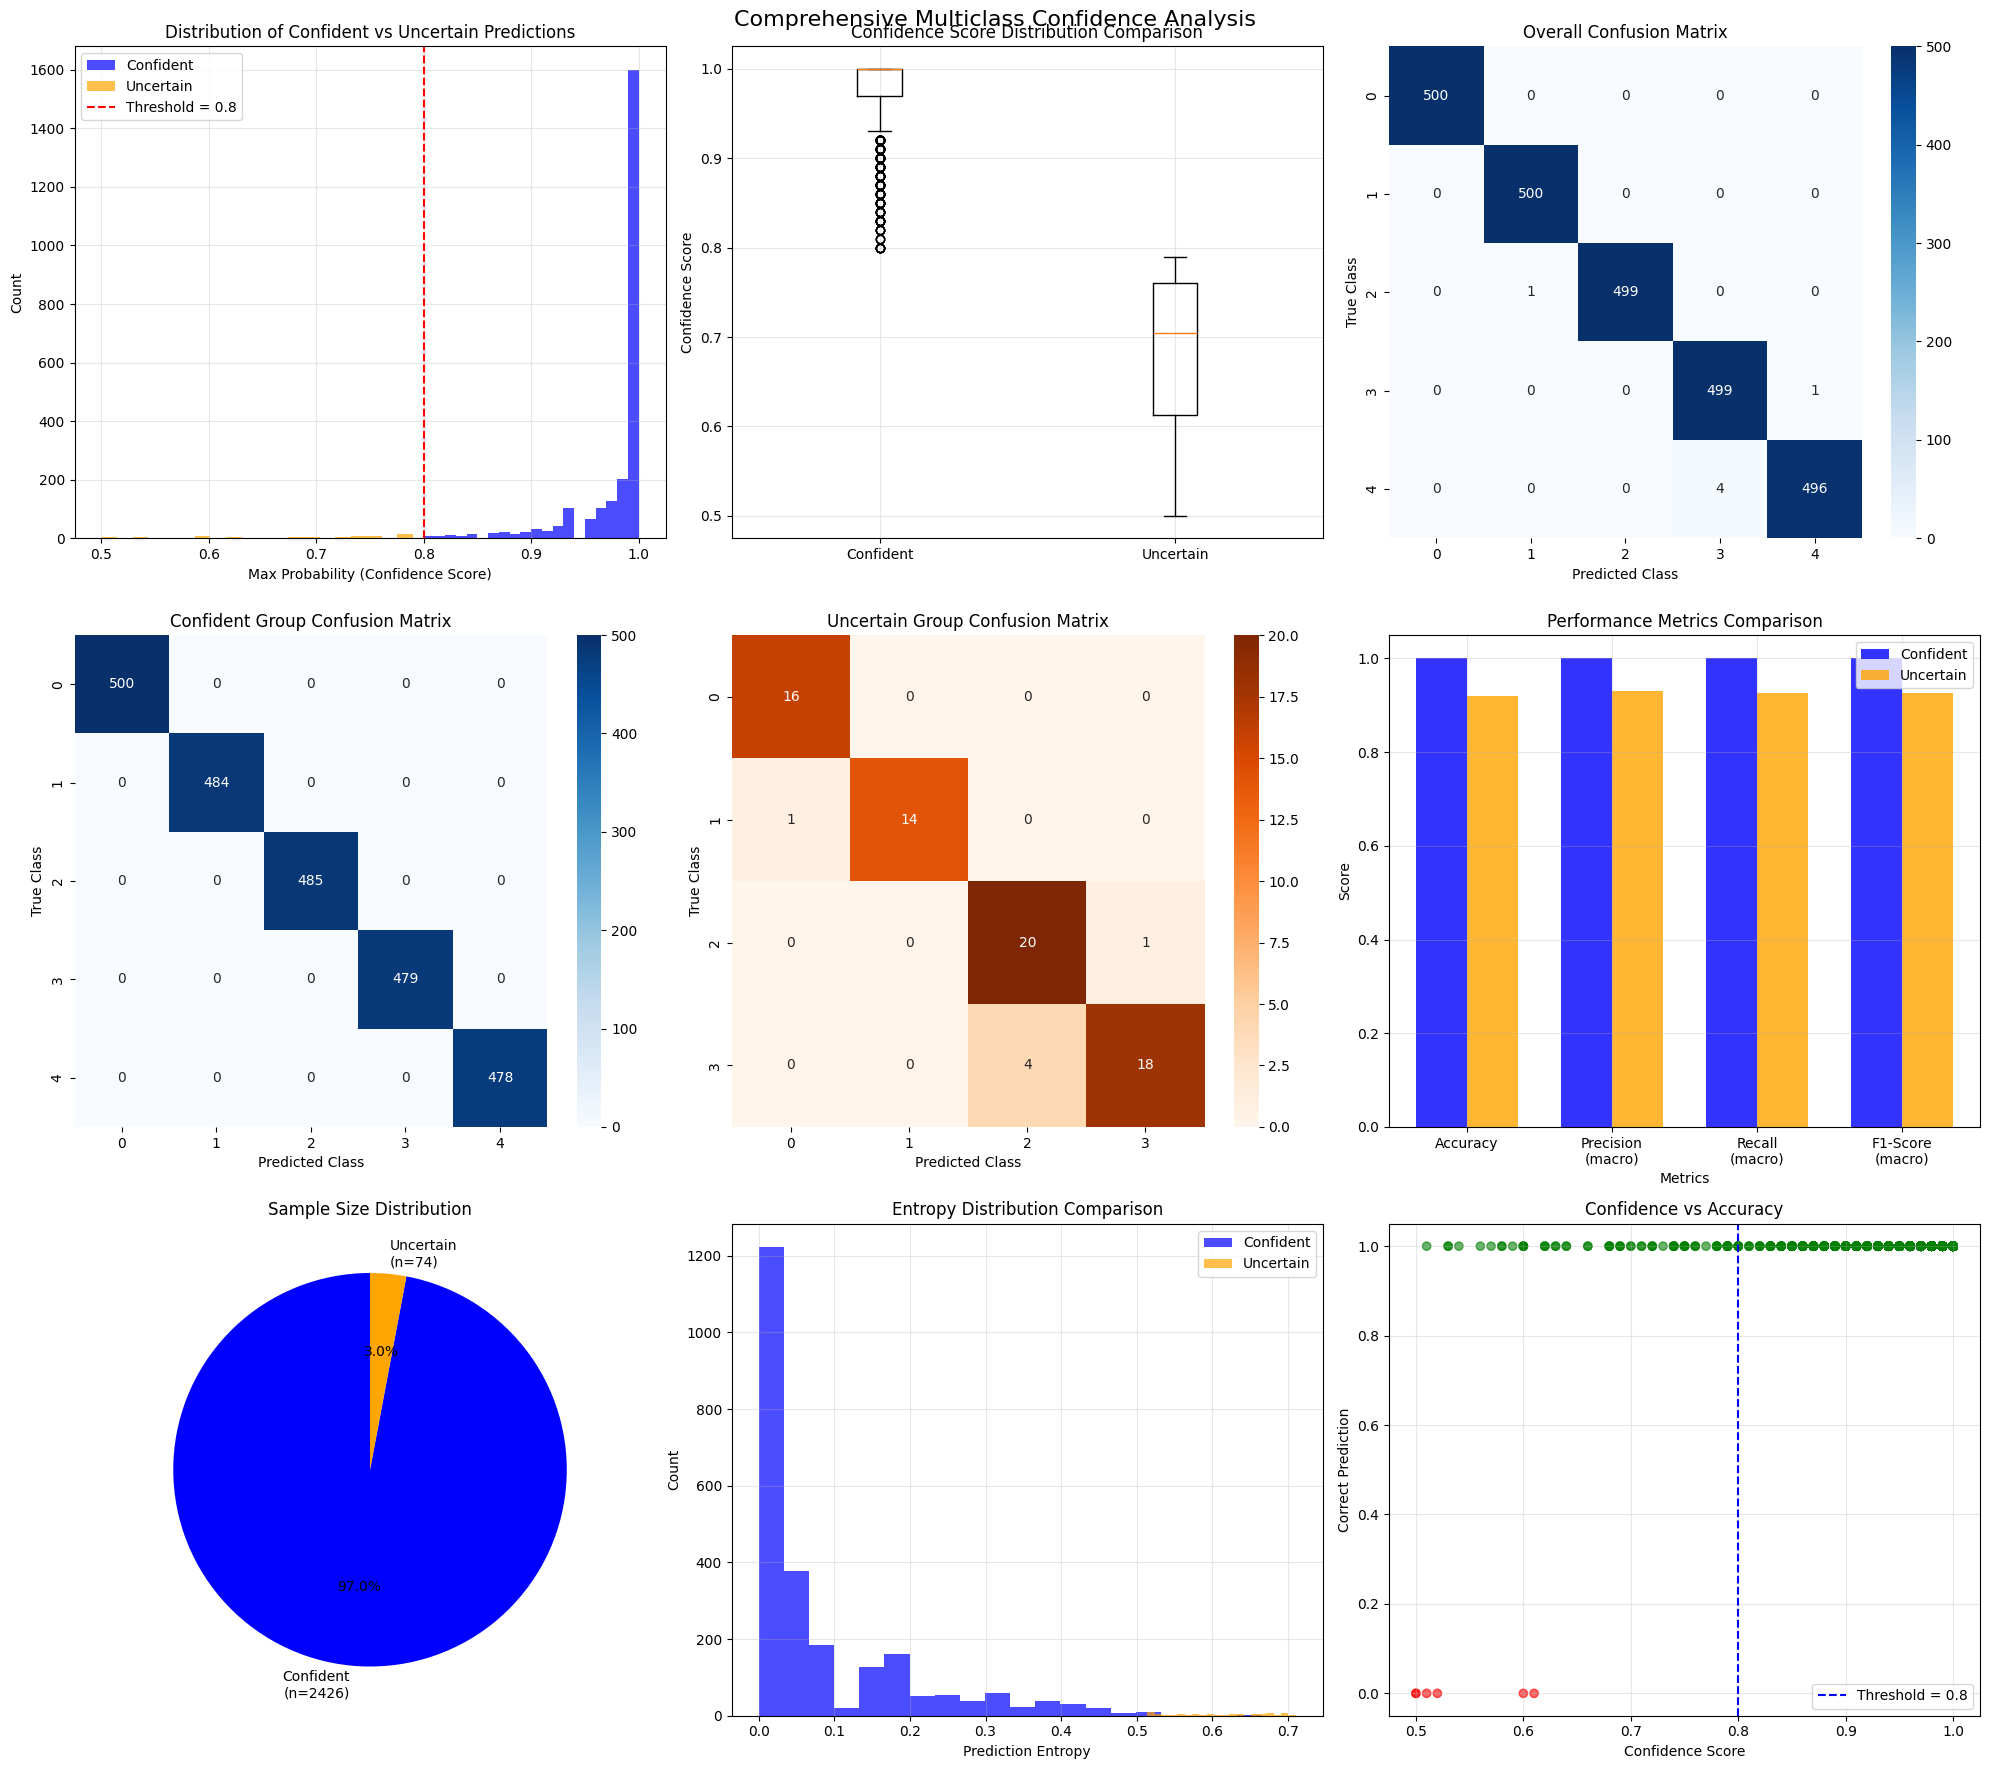


SUMMARY REPORT - MULTICLASS CONFIDENCE ANALYSIS
Key Findings:
• Overall model accuracy: 0.998
• Confident predictions accuracy: 1.000 (n=2426)
• Uncertain predictions accuracy: 0.919 (n=74)
• Confidence strategy effectiveness: 0.081
• Confident predictions ratio: 0.970
• Average confidence score: 0.970
• Number of classes: 5

Recommendations:
✓ The confidence-based splitting is effective - confident predictions are more accurate
  Consider using this threshold for selective prediction or human review systems
⚠ Very high confidence ratio (97.0%) - threshold might be too low
• Average confidence for correct predictions: 0.971
• Average confidence for incorrect predictions: 0.540
✓ Model shows good calibration - higher confidence for correct predictions


In [31]:
# Example usage:
analyzer = MulticlassConfidenceAnalyzer(y_val, y_val_prob, confidence_threshold=0.8)
analyzer.basic_statistics()
analyzer.performance_metrics()
analyzer.statistical_tests()
analyzer.entropy_analysis()
analyzer.create_comprehensive_plots()
analyzer.generate_summary_report()